In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import multivariate_normal

In [2]:
df = pd.read_csv('same_day.csv')
# df_same.head()


         Distance  Last OP Time  Time Difference
3596034      11.4           264              718
198779        8.2            12              770
1595802      47.9           490              105
5148491      16.6            56              820
1404955       8.8             8              862


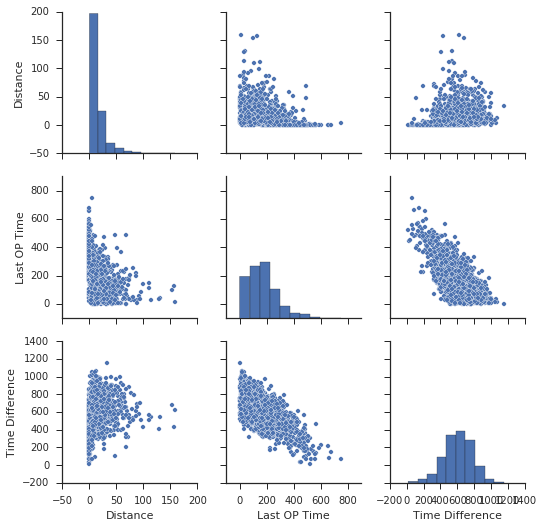

In [4]:
df = df[(df['dif'] < 1500) & (df['distance'] < 200)]
df.columns = ['Distance', 'Last OP Time', 'Time Difference']
s = df.sample(2000)
print s.head()
sns.set(style="ticks", color_codes=True)
sns.pairplot(s)
sns.plt.show() 

In [5]:
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode() 

trace1 = go.Scatter3d(
    x=s['distance'],
    y=s['fac'],
    z=s['dif'],
    mode='markers',
    marker=dict(
        size=5,
        opacity=0.5
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    title="Mailpieces",
    scene = dict(
        xaxis=dict(
            title="Distance"
        ),
        yaxis=dict(
            title="Last Processing Time"
        ),
        zaxis=dict(
            title="Delivery Time"
        ))
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig, filename='Mailpieces')

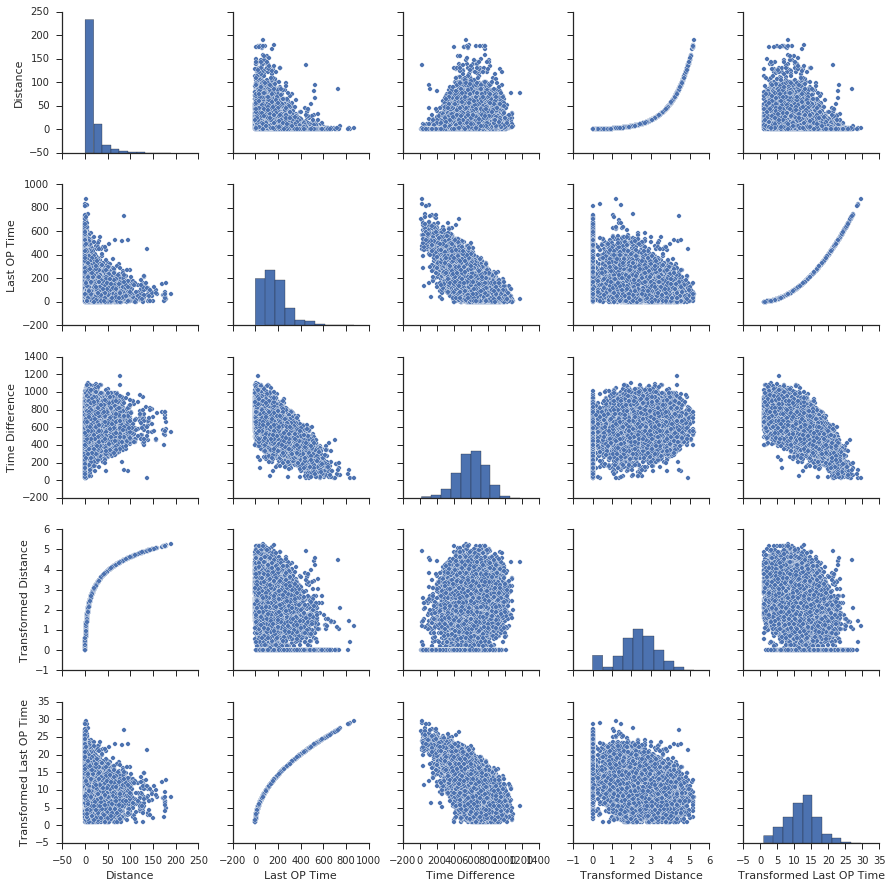

In [5]:
# ['Distance', 'Last OP Time', 'Time Difference']
df['Transformed Distance'] = (df['Distance'] + 1).apply(math.log)
df['Transformed Last OP Time'] = (df['Last OP Time'] + 1).apply(lambda x: x ** (1./2))
s = df.sample(20000)
sns.set(style="ticks", color_codes=True)
sns.pairplot(s)
sns.plt.show() 

In [6]:
# ['Distance', 'Last OP Time', 'Time Difference']
df_gaus = df[['Transformed Distance', 'Transformed Last OP Time', 'Time Difference']]
data = df_gaus.values
mean = np.mean(data, axis=0)
cov = np.cov(data, rowvar=0)
print "mean: {}".format(mean)
print "covariance: \n{}".format(cov)

mean: [   2.31438137   12.13751671  607.79913373]
covariance: 
[[  1.05981219e+00  -1.85530245e+00   4.44947734e+01]
 [ -1.85530245e+00   2.01593102e+01  -4.43895228e+02]
 [  4.44947734e+01  -4.43895228e+02   2.72478534e+04]]


In [7]:
p = multivariate_normal.pdf(data, mean=mean, cov=cov)
k = 10
idx = np.argpartition(p, k)
print np.sort(p[idx[:k]])

[  4.34284657e-13   7.05473578e-13   7.58246405e-13   1.19496277e-12
   2.05406205e-12   2.23365518e-12   2.23709113e-12   3.27498477e-12
   4.60937803e-12   6.50844224e-12]


In [40]:
import string
new_data = np.hstack((df[['Distance', 'Last OP Time', 'Time Difference']].values, p[:, np.newaxis]))
new_df = pd.DataFrame(new_data, columns=['Distance', 'Last OP Time', 'Time Difference', 'p'])
new_df['Anomalies'] = (new_df['p'] <= 1.0e-11)
# print new_df.head()

anoms_print = new_df[new_df['Anomalies'] == True].sort_values(['p'])
anoms_print['Last OP Time2'] = (anoms_print['Last OP Time'] / 60).apply(round).astype(int).astype(str) + ":" + (anoms_print['Last OP Time'] % 60).apply(lambda x: "%02d" % x)
anoms_print['Time Difference2'] = (anoms_print['Time Difference'] / 60).apply(round).astype(int).astype(str) + ":" + (anoms_print['Time Difference'] % 60).apply(lambda x: "%02d" % x)
anoms_print = anoms_print[['Distance', 'Last OP Time2', 'Time Difference2', 'p']]
anoms_print.columns = [['Distance', 'Last OP Time', 'Time Difference', 'p']]
anoms = new_df[new_df['Anomalies'] == True]
anoms_print.head(15)
# s = new_df.sample(2000)
# frames = [s, anoms]
# s2 = pd.concat(frames)
# sns.set(style="ticks", color_codes=True)
# sns.pairplot(s2[['Distance', 'Last OP Time', 'Time Difference', 'Anomalies']], hue="Anomalies")
# sns.plt.show() 

Distance Last OP Time Time Difference             p
52288         0.0         0:07            3:44  4.342847e-13
5370724       0.0         0:01            4:02  7.054736e-13
1621330       0.0         0:08            3:52  7.582464e-13
5992480       0.7         0:09            2:13  1.194963e-12
3160836     124.0        14:52            0:16  2.054062e-12
2229150     138.2        14:48            1:57  2.233655e-12
5272008       0.0         0:05            4:48  2.237091e-12
639152      120.6        14:32            0:17  3.274985e-12
5810653       0.7         0:19            2:57  4.609378e-12
728988      139.2        13:39            1:52  6.508442e-12
1090946       0.0         1:34            2:53  6.636091e-12
3051621     119.6        13:17            1:50  6.748973e-12
232356        0.0         1:34            2:57  7.645420e-12
140600        0.0         1:35            2:57  8.575087e-12

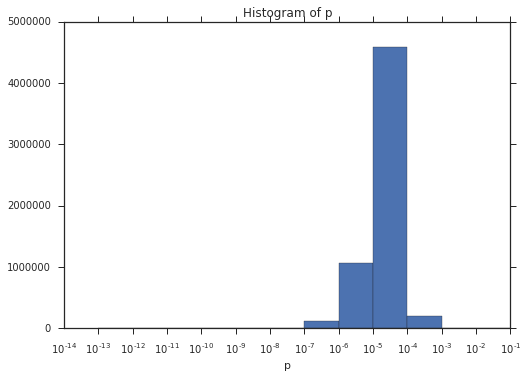

In [41]:
import matplotlib.pyplot as plt

bins = 10.0**(np.arange(-14,0))
plt.xscale('log')
# plt.yscale('log')
plt.hist(series,bins=bins) 
plt.title("Histogram of p")
plt.xlabel("p")
plt.show()

In [10]:
trace1 = go.Scatter3d(
    x=s2.loc[s2['anom'] == False, 'distance'],
    y=s2.loc[s2['anom'] == False, 'fac'],
    z=s2.loc[s2['anom'] == False, 'dif'],
    mode='markers',
    marker=dict(
        size=5,
        opacity=0.5
    )
)

trace2 = go.Scatter3d(
    x=s2.loc[s2['anom'] == True, 'distance'],
    y=s2.loc[s2['anom'] == True, 'fac'],
    z=s2.loc[s2['anom'] == True, 'dif'],
    mode='markers',
    marker=dict(
        color='rgb(50,205,50)',
        size=5,
        opacity=0.5
    )
)

data = [trace1, trace2]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    title="Mailpieces",
    scene = dict(
        xaxis=dict(
            title="Distance"
        ),
        yaxis=dict(
            title="Last Processing Time"
        ),
        zaxis=dict(
            title="Delivery Time"
        ))
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig, filename='Mailpieces')